In [1]:
import os
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

In [2]:
# ====== Config ======
IMG_SIZE = 224
SLICE_STEP = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3
CSV_PATH = "/kaggle/input/fmri-2-6-9/combined.csv"  # đường dẫn đến file .csv chứa nhãn và đường dẫn file .nii

# ====== Dataset đọc .nii theo danh sách từ CSV ======
class NiiSliceDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.data = []
        self.targets = []

        for i, file_path in enumerate(file_paths):
            img_nii = nib.load(file_path)
            img_data = img_nii.get_fdata()  # H, W, D hoặc H, W, D, T

            # Chuyển 4D -> 3D nếu cần
            if img_data.ndim == 4:
                img_data = np.mean(img_data, axis=-1)

            img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data) + 1e-5)
            img_data = np.transpose(img_data, (2, 0, 1))  # D, H, W

            for d in range(0, img_data.shape[0], SLICE_STEP):
                slice_img = img_data[d]
                slice_img = cv2.resize(slice_img, (IMG_SIZE, IMG_SIZE))
                rgb_img = np.stack([slice_img] * 3, axis=0)  # [3, H, W]
                self.data.append(rgb_img.astype(np.float32))
                self.targets.append(labels[i])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.targets[idx]
        img = torch.tensor(img)
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label)

# ====== Load dữ liệu từ CSV ======
df = pd.read_csv(CSV_PATH)
file_paths = df["file_path"].tolist()
labels_raw = df["DIAGNOSIS"].astype(int).tolist()         # Từ float → int
labels_encoded = [lbl - 1 for lbl in labels_raw]      # Đưa về 0, 1, 2
# Chia tập train/val

train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels_encoded, test_size=0.2, stratify=labels_encoded)

# ====== DataLoader ======
# transform = transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
])
train_dataset = NiiSliceDataset(train_paths, train_labels, transform=transform)
val_dataset = NiiSliceDataset(val_paths, val_labels, transform=transform)



In [5]:
# ====== Mô hình EfficientNet ======
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR


EPOCHS = 50
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = timm.create_model("efficientnet_b0", pretrained=True, num_classes=NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 1.8433 | Train Acc: 0.3930


  2%|▏         | 1/50 [01:07<55:29, 67.95s/it]

→ Validation Accuracy: 0.3907
[Epoch 2] Train Loss: 1.2937 | Train Acc: 0.4246


  4%|▍         | 2/50 [02:14<53:52, 67.35s/it]

→ Validation Accuracy: 0.3915
[Epoch 3] Train Loss: 1.1506 | Train Acc: 0.4628


  6%|▌         | 3/50 [03:22<52:50, 67.46s/it]

→ Validation Accuracy: 0.3948
[Epoch 4] Train Loss: 1.0516 | Train Acc: 0.4791


  8%|▊         | 4/50 [04:29<51:43, 67.46s/it]

→ Validation Accuracy: 0.4230
[Epoch 5] Train Loss: 0.9959 | Train Acc: 0.5101


 10%|█         | 5/50 [05:37<50:37, 67.51s/it]

→ Validation Accuracy: 0.4337
[Epoch 6] Train Loss: 0.9730 | Train Acc: 0.5249


 12%|█▏        | 6/50 [06:44<49:25, 67.39s/it]

→ Validation Accuracy: 0.4270
[Epoch 7] Train Loss: 0.9326 | Train Acc: 0.5446


 14%|█▍        | 7/50 [07:51<48:10, 67.21s/it]

→ Validation Accuracy: 0.4400
[Epoch 8] Train Loss: 0.9144 | Train Acc: 0.5548


 16%|█▌        | 8/50 [08:58<46:55, 67.04s/it]

→ Validation Accuracy: 0.4478
[Epoch 9] Train Loss: 0.8786 | Train Acc: 0.5804


 18%|█▊        | 9/50 [10:05<45:46, 66.99s/it]

→ Validation Accuracy: 0.4537
[Epoch 10] Train Loss: 0.8387 | Train Acc: 0.5980


 20%|██        | 10/50 [11:12<44:39, 67.00s/it]

→ Validation Accuracy: 0.4515
[Epoch 11] Train Loss: 0.7930 | Train Acc: 0.6265


 22%|██▏       | 11/50 [12:19<43:32, 67.00s/it]

→ Validation Accuracy: 0.4496
[Epoch 12] Train Loss: 0.7622 | Train Acc: 0.6413


 24%|██▍       | 12/50 [13:25<42:24, 66.95s/it]

→ Validation Accuracy: 0.4619
[Epoch 13] Train Loss: 0.7188 | Train Acc: 0.6715


 26%|██▌       | 13/50 [14:32<41:15, 66.91s/it]

→ Validation Accuracy: 0.4541
[Epoch 14] Train Loss: 0.6815 | Train Acc: 0.6898


 28%|██▊       | 14/50 [15:39<40:08, 66.91s/it]

→ Validation Accuracy: 0.4593
[Epoch 15] Train Loss: 0.6594 | Train Acc: 0.6980


 30%|███       | 15/50 [16:46<39:03, 66.96s/it]

→ Validation Accuracy: 0.4652
[Epoch 16] Train Loss: 0.6120 | Train Acc: 0.7178


 32%|███▏      | 16/50 [17:53<37:59, 67.04s/it]

→ Validation Accuracy: 0.4752
[Epoch 17] Train Loss: 0.5675 | Train Acc: 0.7431


 34%|███▍      | 17/50 [19:01<36:54, 67.10s/it]

→ Validation Accuracy: 0.4781
[Epoch 18] Train Loss: 0.5450 | Train Acc: 0.7551


 36%|███▌      | 18/50 [20:08<35:50, 67.20s/it]

→ Validation Accuracy: 0.4674
[Epoch 19] Train Loss: 0.5146 | Train Acc: 0.7633


 38%|███▊      | 19/50 [21:15<34:42, 67.18s/it]

→ Validation Accuracy: 0.4844
[Epoch 20] Train Loss: 0.4785 | Train Acc: 0.7850


 40%|████      | 20/50 [22:22<33:30, 67.02s/it]

→ Validation Accuracy: 0.4930
[Epoch 21] Train Loss: 0.4537 | Train Acc: 0.7941


 42%|████▏     | 21/50 [23:29<32:23, 67.00s/it]

→ Validation Accuracy: 0.4807
[Epoch 22] Train Loss: 0.4263 | Train Acc: 0.8098


 44%|████▍     | 22/50 [24:36<31:15, 66.99s/it]

→ Validation Accuracy: 0.4804
[Epoch 23] Train Loss: 0.3938 | Train Acc: 0.8249


 46%|████▌     | 23/50 [25:43<30:07, 66.96s/it]

→ Validation Accuracy: 0.4767
[Epoch 24] Train Loss: 0.3810 | Train Acc: 0.8269


 48%|████▊     | 24/50 [26:49<28:57, 66.83s/it]

→ Validation Accuracy: 0.4811
[Epoch 25] Train Loss: 0.3587 | Train Acc: 0.8365


 50%|█████     | 25/50 [27:56<27:51, 66.87s/it]

→ Validation Accuracy: 0.4807
[Epoch 26] Train Loss: 0.3404 | Train Acc: 0.8482


 52%|█████▏    | 26/50 [29:03<26:45, 66.89s/it]

→ Validation Accuracy: 0.4844
[Epoch 27] Train Loss: 0.3332 | Train Acc: 0.8497


 54%|█████▍    | 27/50 [30:10<25:38, 66.87s/it]

→ Validation Accuracy: 0.4970
[Epoch 28] Train Loss: 0.3204 | Train Acc: 0.8541


 56%|█████▌    | 28/50 [31:17<24:30, 66.86s/it]

→ Validation Accuracy: 0.4919
[Epoch 29] Train Loss: 0.3037 | Train Acc: 0.8605


 58%|█████▊    | 29/50 [32:23<23:22, 66.78s/it]

→ Validation Accuracy: 0.4970
[Epoch 30] Train Loss: 0.2784 | Train Acc: 0.8758


 60%|██████    | 30/50 [33:30<22:17, 66.87s/it]

→ Validation Accuracy: 0.4878
[Epoch 31] Train Loss: 0.2666 | Train Acc: 0.8788


 62%|██████▏   | 31/50 [34:38<21:14, 67.09s/it]

→ Validation Accuracy: 0.4956
[Epoch 32] Train Loss: 0.2590 | Train Acc: 0.8823


 64%|██████▍   | 32/50 [35:45<20:07, 67.10s/it]

→ Validation Accuracy: 0.4967
[Epoch 33] Train Loss: 0.2521 | Train Acc: 0.8833


 66%|██████▌   | 33/50 [36:53<19:01, 67.16s/it]

→ Validation Accuracy: 0.4770
[Epoch 34] Train Loss: 0.2381 | Train Acc: 0.8915


 68%|██████▊   | 34/50 [38:00<17:55, 67.20s/it]

→ Validation Accuracy: 0.4941
[Epoch 35] Train Loss: 0.2323 | Train Acc: 0.8946


 70%|███████   | 35/50 [39:07<16:45, 67.05s/it]

→ Validation Accuracy: 0.4852
[Epoch 36] Train Loss: 0.2297 | Train Acc: 0.8950


 72%|███████▏  | 36/50 [40:13<15:36, 66.89s/it]

→ Validation Accuracy: 0.4989
[Epoch 37] Train Loss: 0.2210 | Train Acc: 0.8986


 74%|███████▍  | 37/50 [41:20<14:29, 66.90s/it]

→ Validation Accuracy: 0.5089
[Epoch 38] Train Loss: 0.2179 | Train Acc: 0.9012


 76%|███████▌  | 38/50 [42:27<13:21, 66.81s/it]

→ Validation Accuracy: 0.5022
[Epoch 39] Train Loss: 0.2136 | Train Acc: 0.9062


 78%|███████▊  | 39/50 [43:34<12:15, 66.87s/it]

→ Validation Accuracy: 0.5044
[Epoch 40] Train Loss: 0.2056 | Train Acc: 0.9082


 80%|████████  | 40/50 [44:40<11:08, 66.84s/it]

→ Validation Accuracy: 0.5000
[Epoch 41] Train Loss: 0.2052 | Train Acc: 0.9071


 82%|████████▏ | 41/50 [45:47<10:01, 66.83s/it]

→ Validation Accuracy: 0.4944
[Epoch 42] Train Loss: 0.1973 | Train Acc: 0.9115


 84%|████████▍ | 42/50 [46:54<08:54, 66.78s/it]

→ Validation Accuracy: 0.4907
[Epoch 43] Train Loss: 0.1981 | Train Acc: 0.9096


 86%|████████▌ | 43/50 [48:01<07:47, 66.81s/it]

→ Validation Accuracy: 0.5081
[Epoch 44] Train Loss: 0.1979 | Train Acc: 0.9090


 88%|████████▊ | 44/50 [49:07<06:40, 66.76s/it]

→ Validation Accuracy: 0.4985
[Epoch 45] Train Loss: 0.1941 | Train Acc: 0.9117


 90%|█████████ | 45/50 [50:14<05:34, 66.87s/it]

→ Validation Accuracy: 0.4967
[Epoch 46] Train Loss: 0.1946 | Train Acc: 0.9108


 92%|█████████▏| 46/50 [51:22<04:28, 67.04s/it]

→ Validation Accuracy: 0.4963
[Epoch 47] Train Loss: 0.1908 | Train Acc: 0.9143


 94%|█████████▍| 47/50 [52:29<03:21, 67.09s/it]

→ Validation Accuracy: 0.4952
[Epoch 48] Train Loss: 0.1924 | Train Acc: 0.9131


 96%|█████████▌| 48/50 [53:36<02:14, 67.18s/it]

→ Validation Accuracy: 0.5074
[Epoch 49] Train Loss: 0.1961 | Train Acc: 0.9081


 98%|█████████▊| 49/50 [54:43<01:07, 67.06s/it]

→ Validation Accuracy: 0.5000
[Epoch 50] Train Loss: 0.1897 | Train Acc: 0.9130
→ Validation Accuracy: 0.4885
Classification Report:
              precision    recall  f1-score   support

      Normal       0.53      0.47      0.50      1064
         MCI       0.49      0.58      0.53      1108
          AD       0.40      0.35      0.37       528

    accuracy                           0.49      2700
   macro avg       0.47      0.46      0.47      2700
weighted avg       0.49      0.49      0.49      2700



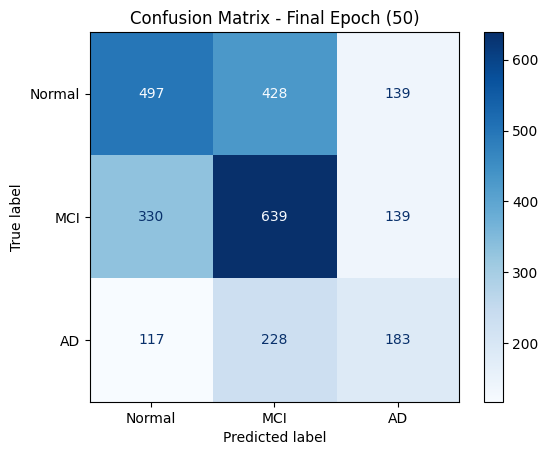

100%|██████████| 50/50 [55:50<00:00, 67.02s/it]


In [6]:
# ====== Vòng lặp huấn luyện ======
for epoch in tqdm(range(EPOCHS)):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_loader.dataset)
    total = total_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {total:.4f} | Train Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(1)

            val_correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)
    print(f"→ Validation Accuracy: {val_acc:.4f}")

    

    # ====== Chỉ vẽ confusion matrix ở epoch cuối ======
    if epoch == EPOCHS - 1:
        print("Classification Report:")
        print(classification_report(all_labels, all_preds, target_names=["Normal", "MCI", "AD"]))
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "MCI", "AD"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - Final Epoch ({epoch+1})")
        plt.show()

    scheduler.step()  # CosineAnnealingLR